In [4]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

N = 10 #number of neurons
Vseuil = 60 #the threshold of activation of neuron, in mV, global variable, used in functions
Vmax = 120 #Vmax maximum can be attained
Vmin= -20 #Vmin minimum can be attained
Vmin_ma = -20
tau = 10
tPA = 1
deltaT = 0.1
tPH = 0.6
tH = 1.2
alpha = 0.1
nb_steps = 100 #number of simulation
beta=0.55 #beta*Vmax

In [5]:
### Functions for initiations
def init_syst_links():
    """Create a matrix of 2 dimensions which shows the connections between neurons in the system.
    Initiated randomly and stay the same always. (a transpose matrix of the regular matrix)
    syst_links[i][j] = 1: j connects and can send signal to i, not in reverse
    syst_links[i][j] = 0: j doesnt connect to i
    syst_links[i][i] = k: the decrease factor of potential of the neuron i"""
    syst_links = np.random.rand(N, N)
    for i in range(N):
        for j in range(N):
            if i != j:
                syst_links[i][j] = random.choice([0.0, 1.0]) * (-1) * random.choice([0, 1])
            else:
                syst_links[i][j] = 1./beta
    syst_links.transpose()
    return syst_links

In [6]:
def init_syst_potentiel():
    """Create a matrix of 2D which shows the potential of each neuron at time t of the simulation.
    Initiated randomly.
    syst_potentiel[i][j] = 0 for every i != j;
    syst_potentiel[i][i] = value of potential of neuron i"""

    syst_potentiel = np.zeros((N, N), dtype=float)
    return syst_potentiel

In [7]:
def init_syst_state():
    """Create a matrix of size(nb_neuron,1) which shows the state of activation of a neuron.
    Initiated randomly.
    syst_act[i][0] = 0: neuron i isnt activated, it cant send signal to others
    syst_act[i][0] = 1: neuron i is activated and can send signal to others
    When the potential of a neuron i passes the threshold, syst_act[i][0] = 1 at the next step
    After release all its potential, syst_act[i][0] = 0 at the next step"""

    syst_state = np.zeros((N,1), dtype=int)
    return syst_state

In [8]:
def matrix_Ni(i):
    """Create a matrix 2D which helps keeping the potential of each neuron of the previous step to the next step
    Size: (nb_neuron,1)
    Only the i of the neuron in current execution is set to 1. All the others elements are 0."""

    matrix_Ni = np.zeros((N,1), dtype=int)
    matrix_Ni[i][0] = 1
    return matrix_Ni

In [9]:
def init_syst_phase():
    """Create a matrix of size (N,1) which keeps tracks of the phase of all the neurons in the system.
    There are 5 phases stated in the document of algorithme."""

    syst_phase = np.zeros((N, 1), dtype=float)
    return syst_phase

In [10]:
def init_syst_lambda():
    """Create a matrix of size (N,1) which helps keep tracks of the coefficient lambda which decides the pourcentage
    of Vmax can be attained in the next depolarisation."""

    syst_lambda = np.ones((N, 1), dtype=float)
    return syst_lambda

In [11]:
def init_time_rest():
    """Create a matrix of size (N,1) which count the steps taken by all neurons of the system after they were depolarised"""

    time_rest = np.zeros((N, 1), dtype=float)
    return time_rest

In [12]:
def func_act_0(potentiel):
    """float -> float
    The function activate of the system is to modify the potential of each neuron corresponding
    to its current phase = 0 and depending on its sum of reception from others"""
    #V_new: potential of neuron after affected by the activate function
    V_new=0
    if potentiel > 0:
        if potentiel < Vseuil:
            V_new = potentiel*math.exp(-1. / tau * math.log(100*Vseuil))
        else:
            V_new = Vseuil
    elif potentiel < 0:
        if potentiel > Vmin :
            V_new = potentiel * math.exp(-1. / tau * math.log(100 * abs(Vmin_ma)))
        else :
            V_new = Vmin
    return V_new

def func_act_1(potentiel, lamb):
    """float -> float
    The function activate of the system is to modify the potential of each neuron corresponding
    to its current phase = 1 and depending on its sum of reception from others"""
    #V_new: potential of neuron after affected by the activate function
    V_new = potentiel + (2 * lamb * (Vmax - Vseuil) * deltaT / (tPA - deltaT))
    var = lamb * (Vmax - Vseuil) + Vseuil  # var temporary to stock the value of Vmax of the current depolarisation
    if V_new >= var:
        V_new = var
    return V_new

def func_act_2(potentiel, lamb):
    """float -> float
    The function activate of the system is to modify the potential of each neuron corresponding
    to its current phase = 2 and depending on its sum of reception from others"""
    #V_new: potential of neuron after affected by the activate function
    V_new = potentiel - (2 * lamb * (Vmax - Vseuil) * deltaT / (tPA - deltaT))
    if V_new <= Vseuil:
        V_new = Vseuil
    return V_new

def func_act_3(potentiel, lamb):
    """float -> float
    The function activate of the system is to modify the potential of each neuron corresponding
    to its current phase = 3 and depending on its sum of reception from others"""
    #V_new: potential of neuron after affected by the activate function
    V_new = potentiel - (Vseuil - lamb * Vmin * deltaT) / (math.exp(alpha * (1-lamb)) * tPH)
    if V_new < lamb * Vmin:
        V_new = lamb * Vmin
    return V_new

def func_act_4(potentiel, lamb):
    """float -> float
    The function activate of the system is to modify the potential of each neuron corresponding
    to its current phase = 4 and depending on its sum of reception from others"""
    #V_new: potential of neuron after affected by the activate function
    V_new = potentiel - (lamb * Vmin * deltaT / (math.exp(alpha * (1-lamb)) * tH))
    if V_new > 0:
        V_new = 0
    return V_new

In [13]:
def update_lamb(lamb, time_rest):
    new_lamb = 1-(time_rest / (math.exp(alpha * (1-lamb)) * (tPH + tH) + deltaT))
    return new_lamb

In [14]:
def give_time_ar(lamb):
    return math.exp(alpha * (1-lamb)) * (tPH + tH) + deltaT

In [15]:
def start_syst(syst_potentiel, syst_state, syst_phase):
    """Send in the information in form electric ranged between 0 and (Vseuil + Vmax)/2 (mV) to kick off the system.
    we suppose that this function will only be called when there are no transmission in between the neurons and all the
    neurons are at phase 0 (we still wait until the neurones at phase 3 and 4 rest at 0 and turns to phase 0,
    meanwhile, others neurons at phase 0 will still decrease as defined)
     Return None as the parametres given to the function is already modified"""

    for i in range(N):
        syst_potentiel[i][i] = func_act_0(syst_potentiel[i][i] + random.uniform(0, (Vseuil + Vmax)/2))
        if syst_potentiel[i][i] >= Vseuil:
            syst_state[i][0] = 1
            syst_phase[i][0] = 1

In [16]:
def start_syst_1(syst_potentiel, syst_state, syst_phase, syst_lambda, time_rest):
    """Send in the information in form electric ranged between 0 and Vseuil (mV) to kick off the system.
    we suppose that this function will only be called when there are no transmission in between the neurons which means
    all neurons are at phase {0,3,4}. Indeed, if a neuron in phase 3 or 4 is activated after this functions is called,
    the new Vmax will be calculated, else, we have to set its lambda back to 1
    Return None as the parametres given to the function is already modified"""

    for i in range(N):
        syst_potentiel[i][i] = func_act_0(syst_potentiel[i][i] + random.uniform(0, Vseuil))
        if syst_potentiel[i][i] >= Vseuil:
            if syst_phase[i][0] == 3 or syst_phase[i][0] == 4:
                syst_lambda[i][0] = update_lamb(syst_lambda[i][0], time_rest[i][0])
            syst_state[i][0] = 1
            syst_phase[i][0] = 1
        else:
            syst_lambda[i][0] = 1
            syst_phase[i][0] = 0

In [17]:
def non_transmittable(syst_state, syst_phase):
    """Verify if there is no transmission between neurons and all neurons are at phase 0
    This function is compatible with the function start_syst
    return a bool"""
    res = True
    for i in range(N):
        if syst_state[i][0] == 0 or syst_phase[i][0] != 0:
            res = False
            break
    return res

In [18]:
def non_transmittable_1(syst_state):
    """Verify if there is no transmission between neurons
    This function is compatible with the function start_syst_1
    return a bool"""
    res = True
    for i in range(N):
        if syst_state[i][0] == 1:
            res = False
            break
    return res

In [21]:
def update_system(syst_potentiel, syst_links, syst_state, syst_phase, syst_lambda, time_rest):
    """matrix(N,N) ^2 * matrix(N,1) ^5 -> tuple(matrix(N,N), matrix(N,1))
    Calculate the potentials of all the neurons at the time t+1 and also update theirs state at time t+1 (activated or not)
    All neurons will be update simultaneously.
    Return the potentials and their states of the whole system in form matrix."""
    new_syst_potentiel = init_syst_potentiel()
    new_syst_state = copy.deepcopy(syst_state)
    var = 0 #variable temporary
    for i in range(N):
        

        if syst_state[i][0] == 0:
            #if a neuron is not in the potential of action, it will receive from others (phase = {0,3,4})
            var = beta*np.dot(syst_links[i], np.dot(syst_potentiel, syst_state + matrix_Ni(i)) + (-Vseuil) * syst_state)
            
            if time_rest[i][0]>0 :
                time_rest[i][0] = time_rest[i][0]-deltaT
            else :
            #the neuron has wait enough to reach Vmax on the next depolarization
                syst_lambda[i][0]=1
                time_rest[i][0] = 0
        else:
            #else it will not receive transmission from others and behaves as defined ( phase = {1,2})
            var = syst_potentiel[i][i]
        #var stocks the sum of potential that a neuron has after receiving from others (period of transmission between
        #neurones) and before affected by func_act
        
        if syst_phase[i][0] == 0:
            new_syst_potentiel[i][i]=func_act_0(var)
            if new_syst_potentiel[i][i] == Vseuil:
                new_syst_state[i][0] = 1
                syst_phase[i][0] = 1
                
                if time_rest[i][0]!=0 :
                    syst_lambda[i][0] = update_lamb(syst_lambda[i][0], time_rest[i][0])
                    time_rest[i][0]=give_time_ar(syst_lambda[i][0])
                else :
                    time_rest[i][0]=give_time_ar(syst_lambda[i][0])
                

        elif syst_phase[i][0] == 1:
            new_syst_potentiel[i][i] = func_act_1(var, syst_lambda[i][0])
            Vmax_current = syst_lambda[i][0] * (Vmax - Vseuil) + Vseuil
            if new_syst_potentiel[i][i] == Vmax_current:
                syst_phase[i][0] = 2

        elif syst_phase[i][0] == 2:
            new_syst_potentiel[i][i] = func_act_2(var, syst_lambda[i][0])
            if new_syst_potentiel[i][i] == Vseuil:
                new_syst_state[i][0] = 0
                syst_phase[i][0] = 3
                

                
        elif syst_phase[i][0] == 3:
                   
            if var!=syst_potentiel[i][i] :
                syst_phase[i][0] = 0
                new_syst_potentiel[i][i]=func_act_0(var)
                
            else:
                #the neuron in phase 3 doesn't receive any potential from others so it will continue to decrease by the
                #function defined for this phase
                new_syst_potentiel[i][i] = func_act_3(var, syst_lambda[i][0])
                
                if new_syst_potentiel[i][i] == syst_lambda[i][0] * Vmin:
                    syst_phase[i][0] = 4

        elif syst_phase[i][0] == 4:
            
            if var!=syst_potentiel[i][i] :
                syst_phase[i][0] = 0
                new_syst_potentiel[i][i]=func_act_0(var)
                 
            else:
                new_syst_potentiel[i][i] = func_act_4(var, syst_lambda[i][0])
                
                    
                if new_syst_potentiel[i][i] == 0:
                    #after a neuron of phase 4 reaches 0, everything is set back to starting point
                    syst_phase[i][0] = 0
                    
    
    return (new_syst_potentiel, new_syst_state,time_rest)


In [22]:
def simulation(syst_potentiel, syst_links, syst_state, syst_phase, syst_lambda, time_rest, nb_steps):
    """Return a list of all the matrixes, each matrix shows the potentials of the system
    at moment t"""
    # res_potentiels: list[matrix(N,N)]
    #res_states: list[matrix(N,1)]
    res_potentiels = []
    res_states = []
    res_lambda=[]
    res_time=[]
    res_phase=[]

    new_p = copy.deepcopy(syst_potentiel)
    res_potentiels.append(new_p.copy())
    new_s = copy.deepcopy(syst_state)
    res_states.append(new_s)
    res_time.append(copy.deepcopy(time_rest))
    res_phase.append(copy.deepcopy(syst_phase))

    for i in range(nb_steps):
        #if non_transmittable_1(new_s):
            #normally it's improbable for this condition to occur when the neural network contains millions of neurons
            #but in the system with a small number of neuron, this condition makes sure the system will run continuously
            #start_syst_1(new_p, new_s, syst_phase, syst_lambda, time_rest)
        #else:
        new_p, new_s,time_rest = update_system(new_p, syst_links, new_s, syst_phase, syst_lambda, time_rest)

        res_potentiels.append(copy.deepcopy(new_p))
        res_states.append(copy.deepcopy(new_s))
        res_lambda.append(copy.deepcopy(syst_lambda))
        res_time.append(copy.deepcopy(time_rest))
        res_phase.append(copy.deepcopy(syst_phase))
        
    return (res_potentiels, res_states,res_lambda,res_time,res_phase)

In [23]:
Vt = init_syst_potentiel()
C = init_syst_links()
Tt = init_syst_state()
E = init_syst_phase()
lamb = init_syst_lambda()
Tar = init_time_rest()

In [24]:
start_syst(Vt, Tt, E)
res_potentials, res_states,res_lambda,res_time,res_phase = simulation(Vt, C, Tt, E, lamb, Tar, nb_steps)

In [27]:
i=0
#print(res_time[i])
#print(res_phase[i])
res_potentials[i]

array([[ 60.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   2.05404873,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   6.47955815,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  60.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         21.88874332,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  60.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [28]:
import numpy as np
beta=0.5

Vt = init_syst_potentiel()
C = init_syst_links()
Tt = init_syst_state()
E = init_syst_phase()
lamb = init_syst_lambda()
Tar = init_time_rest()


res_pot=[]
r=[]

Vt[0][0]=0
Vt[1][1]=0
Tt[0][0]=0
Tt[1][0]=0
E[0][0]=0
E[1][0]=0
new_p = copy.deepcopy(Vt)
new_s = copy.deepcopy(Tt)

for k in range(N):
    if(k!=0):
        C[0][k]=0
        C[k][0]=0
C[0][1]=1
C[0][2]=1
#set only one entry for the neuron one
res_pot=[]


In [79]:
i=1

stimu1=0 #stimu=1 : simulate an entry / stimu=0 no entry for the neuron one
stimu2=0

if stimu1==1 :
    if(new_s[1][0]!=1):
        new_p[1][1]=Vseuil
        new_s[1][0]=1
        E[1][0]=1
        lamb[1][0]=1
        print("neurone 1 : fin de dépolarisation")

if stimu2==1:
    if(new_s[2][0]!=1):
        new_p[2][2]=Vseuil
        new_s[2][0]=1
        E[2][0]=1
        lamb[2][0]=1
        print("neurone 2 : fin de dépolarisation")


    
if(new_s[0][0]==1):
    print("dépolarisation")
    for k in range(int(tPA/deltaT)):
        new_p, new_s,r = update_system(new_p, C, new_s, E, lamb, Tar)
        res_pot.append(new_p[0][0])
else:
    new_p, new_s,r = update_system(new_p, C, new_s, E, lamb, Tar)
    res_pot.append(new_p[0][0])
    
print("potentiel neurone 0 : "+str(new_p[0][0]))



potentiel neurone 0 : 0.000947799306079


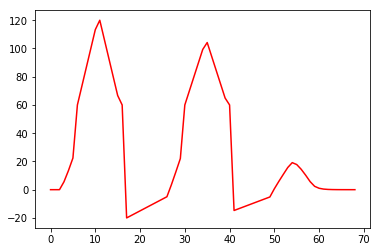

In [80]:
plt.plot([i for i in range(len(res_pot))],res_pot,color='red')
plt.show()

In [3972]:
lamb=1
2/(math.exp(alpha * (1-lamb)) * (tPH + tH) + deltaT)

1.0526315789473684